In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV

In [2]:
# load list of protein IDs as dataframe
ID_file = 'data/processed/gastric_ID_list.csv'
gastric_ID = pd.read_csv(ID_file, index_col=0)
gastric_ID.reset_index(drop=True, inplace=True)
gastric_ID

,ID
0,P06493
1,P35237
2,P02655
3,Q00341
4,P46781
...,...
3909,R4GMX3
3910,Q5VZ89
3911,S4R303
3912,V9GYT7


In [22]:
file = 'data/processed/gastric_clean_unst.csv'

In [23]:
# load gastric dataset as dataframe
gastric_df = pd.read_csv(file, index_col=0)
gastric_df.reset_index(drop=True, inplace=True)
gastric_df

,NC1 Log2,NC2 Log2,NC3 Log2,NC4 Log2,GC1 Log2,GC2 Log2,GC3 Log2,GC4 Log2,PL1 Log2,PL2 Log2,...,RNA degradation,Mismatch repair,Stomach specific,Mitochondrion,Cytoplasm,Extracellular exosome,Membrane,Nucleus,Endoplasmic reticulum,Golgi apparatus
0,14.141872,14.107314,13.862564,13.757528,14.283957,13.844870,14.446062,14.238953,14.157263,13.412358,...,0,0,0,1,1,1,1,1,0,0
1,18.189801,18.202496,18.049074,18.069828,18.372977,18.240611,18.414903,18.385577,18.464838,18.382029,...,0,0,0,0,1,1,0,1,0,0
2,15.370743,15.220339,14.877490,14.877915,15.250045,15.182754,15.617631,15.404629,15.313874,14.679077,...,0,0,0,0,0,1,0,0,0,0
3,20.695419,20.764910,20.609847,20.648786,20.419828,20.184950,20.393157,20.341481,20.694539,20.345622,...,0,0,0,0,1,0,0,1,0,0
4,19.076272,19.118719,19.159973,19.142240,18.936441,18.792552,18.894393,18.742887,18.848415,18.776311,...,0,0,0,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3909,12.901462,13.211006,13.401413,13.283953,13.499713,13.480609,13.207380,13.471890,13.221693,13.314391,...,0,0,0,0,1,0,0,1,0,0
3910,14.153375,14.074614,14.294366,14.275029,14.141097,14.475560,14.173025,14.205150,14.154766,14.456927,...,0,0,0,0,0,0,0,0,0,0
3911,14.537214,14.515092,14.198650,14.548186,13.307382,13.813228,13.612146,13.882917,14.146743,14.460718,...,0,0,0,0,1,0,0,1,0,0
3912,13.652200,13.503825,12.866414,13.433816,13.270009,12.735903,13.123058,13.411304,13.479893,12.886742,...,0,0,0,0,0,0,0,1,0,0


## random forest classifier (supervised learning) 

In [27]:
# common proteins in TB and sarcoidosis data
file = 'data/processed/gran_all_ID.csv'
gran_prot = pd.read_csv(file)
gran_prot.reset_index(drop=True, inplace=True)

### preparing prediction data set (gastric cancer)

In [29]:
gastric_df['ID'] = gastric_ID
gastric_df.to_csv('data/processed/gastric_loc_ID.csv')

In [30]:
TB_gastric_prot = []

# find index in gastric dataset that match ID in common granuloma proteins
for i in range(len(gran_prot)):
    ind = gastric_df.index[gastric_df['ID'] == gran_prot['ID'][i]].tolist()
    TB_gastric_prot = TB_gastric_prot + ind

In [31]:
# make gastric dataframe (test set) with only overlapping proteins
g = gastric_df.iloc[TB_gastric_prot].T
g.columns = g.iloc[-1]

# delete irrelevant rows
to_del = list(range(12,47))
g = g.drop(g.index[to_del])

### preparing training data set (TB/sarc)

In [32]:
file = 'data/processed/TB_sarc_overlap.csv'
# load granuloma dataset as dataframe
gran_df = pd.read_csv(file)
gran_df.reset_index(drop=True, inplace=True)

In [33]:
# delete irrelevant data
to_del = [0, 1, 2] + [27, 28, 29] + list(range(31,70))
gran_df = gran_df.drop([gran_df.columns[x] for x in to_del],  axis='columns')

In [34]:
# map protein name to ID
gran_dict = gran_prot.set_index('Antibody target').to_dict()
# append 'Disease' into dictionary
gran_dict['ID']['Disease'] = 'Disease'

In [35]:
# create new columns using ID
new_col = []
for c in gran_df.columns:
    new_col.append(gran_dict['ID'][c])
    
gran_df.columns = new_col

# only keep columns that match the gastric dataframe columns (protein IDs)
ccol = list(g.columns) + ['Disease']
gran_df = gran_df[ccol]
gran_df.to_csv('data/processed/gran_protein9.csv')

### splitting dataset and training model

In [19]:
# split TB/sarcoidosis model 
X_train, X_test, y_train, y_test = train_test_split(gran_df.loc[:, gran_df.columns != 'Disease'], 
                                                         gran_df.Disease, test_size=0.1, random_state = 8,
                                                         stratify = gran_df.Disease)

In [20]:
# create random forest classifier, fit to training, and predict classification on testing 
clf = RandomForestClassifier(bootstrap=True);
clf.fit(X_train, y_train);

In [21]:
# accuracy score
print(clf.score(X_train, y_train), clf.score(X_test, y_test))

0.998804663650741 0.8254033926354986


#### improving RandomForestClassifier

In [70]:
# random grid search
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'log2'],
    'n_estimators': [200, 300, 400]
}

In [71]:
# grid search of parameters, using 3 fold cross validation
rf_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

rf_search.fit(X_train, y_train);
rf_search.best_params_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'n_estimators': 400}

In [72]:
# accuracy score
rf_search.score(X_test, y_test)

0.8337608605709558

### feature importance 

In [75]:
# Gini importance of each feature
feat_import = rf_search.best_estimator_.feature_importances_
gran_feat_df = pd.DataFrame({'Gini importance': feat_import}, index=X_train.columns)
gran_feat_df

,Gini importance
P08670,0.187363
P08571,0.171742
P16284,0.031215
P20702,0.167353
Q86VB7,0.041810
P11215,0.136615
P08575,0.156742
P35908,0.025617
P46013,0.081543


In [76]:
# sort feature indices based on importance to extract top two features
sort_index = np.argsort(feat_import)

top_feat = gran_df.columns[sort_index[-1]]
sec_feat = gran_df.columns[sort_index[-2]]
third_feat = gran_df.columns[sort_index[-3]]
print(top_feat)
print(sec_feat)
print(third_feat)

P08670
P08571
P20702


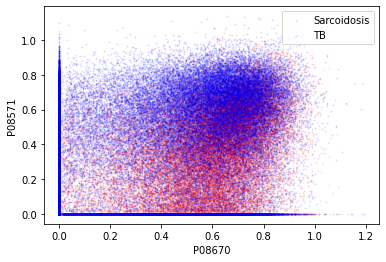

In [77]:
# plot each tumor type label in different color for top important features from random forest classifier
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel(top_feat)
ax.set_ylabel(sec_feat)
targets = [0,1]
colors = ['r', 'b']

for target, color in zip(targets,colors):
    ind = gran_df['Disease'] == target
    ax.scatter(gran_df.loc[ind, top_feat]
               , gran_df.loc[ind, sec_feat]
               , c = color, alpha=0.1, s=1);
    
ax.legend(['Sarcoidosis', 'TB']);
fig.savefig('figures/gran_top2_forest.png')

### predicting gastric data

In [73]:
# classify gastric diseases with random forest classifier 
clf_gastric_pred = rf_search.predict(g)
clf_gastric_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)